# Лабораторная работа №2. Критерии согласия и однородности выборок

> Вариант № 5

**Распределения**:

X ~ N(5,2) (объём выборки $n_x$ &mdash; 100)

Y ~ N(5,2) (объём выборки $n_y$ &mdash; 100)

In [15]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Немного магии для того, чтобы рисунки стали больше
import pylab
pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

# Вспомогательные классы и функции, определённые тут же (см. репозиторий)
# https://github.com/BobNobrain/matstat-labs/tree/master/s
from s import Sample
from s.utils import table

## Задание переменных и генерация выборок

In [16]:
nx = 100
ny = 100

X = stats.norm(5, np.sqrt(2))
Y = stats.norm(5, np.sqrt(2))

# Пример использования класса Sample для получения выборки из заданного распределения
x = Sample.from_distribution("x", X, count=nx)
y = Sample.from_distribution("y", Y, count=ny)
# Альтернатива: X.rvs(size=nx) - массив случайных чисел из заданного распределения

# Вспомогательный метод класса s.Sample
x.describe()
y.describe()

# Отрисовка таблицы: массив заголовочных ячеек, массив строк таблицы
table(
    ['Распределение', 'Параметры', '$m$', '$\\sigma^2$'],
    [
        ['N', 'm=5, $\\sigma^2$=2', X.mean(), X.var()],
        ['N', 'm=5, $\\sigma^2$=2', Y.mean(), Y.var()],
    ]
)

Sample x: m=4.786819956521658, s=1.4142894453633175, s^2=2.0002146352660803
Sample y: m=5.028979676895252, s=1.4566157383015448, s^2=2.1217294090677545


Распределение,Параметры,$m$,$\sigma^2$
N,"m=5, $\sigma^2$=2",5.0,2.0000000000000004
N,"m=5, $\sigma^2$=2",5.0,2.0000000000000004


## 1. Исходные данные

In [17]:
print('Характеристики СВ X:')

table(
    ['Распределение', 'Параметры', 'Мат. ожидание $m$', 'Дисперсия $\\sigma^2$'],
    [[ 'N', '(5,2)', X.mean(), X.var()]]
)

print('Характеристики выборки x')
table(
    ['Среднее, $\\overline{x}$', 'Оценка дисперсии, $s^2$', 'Оценка с.к.о., $s$'],
    [[round(x.mean(), 4), round(x.var(), 4), round(x.s(),4)]]
)

Характеристики СВ X:


Распределение,Параметры,Мат. ожидание $m$,Дисперсия $\sigma^2$
N,"(5,2)",5.0,2.0000000000000004


Характеристики выборки x


"Среднее, $\overline{x}$","Оценка дисперсии, $s^2$","Оценка с.к.о., $s$"
4.7868,1.9802,1.4143


## 2. Визуальное представление выборки

Гистограммы частот для $n_{bins} \in \{5, 10, 15, n_{my}\}$ (выберите $n_{my}$ сами):

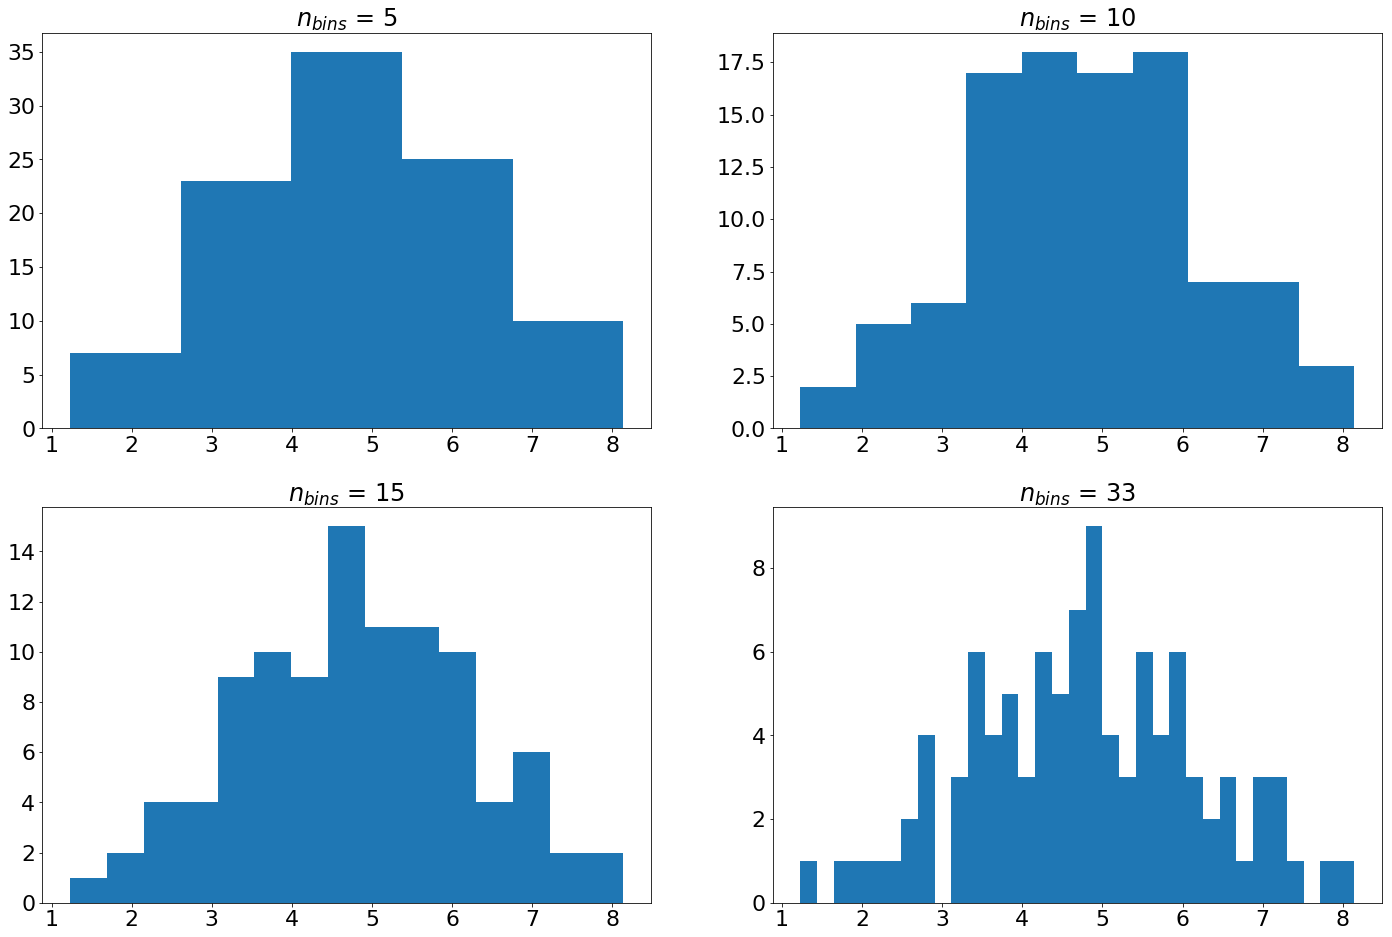

In [18]:
n_my = 33 # TODO: выбрать число
fig, axs = plt.subplots(2,2)

n_bins_values = [5, 10, 15, n_my]

for i in range(4):
    n_bins = n_bins_values[i]
    picture = axs[i // 2][i % 2]
    picture.hist(x.data(), bins=n_bins)
    picture.set_title('$n_{bins}$ = {}'.format(n_bins, bins='{bins}'), fontsize=24)

## 3. Критерий хи-квадрат

*а)* Статистическая гипотеза $H_0: X \sim N$

In [27]:
from s import Pierson1SampledHyp
import math

alpha = 0.01
my_n = 33

normal_dist = stats.norm(X.mean(), X.std())

def table_row(n, proposed_dist, excepted_dec):
    start = math.floor(x.min())
    end = math.ceil(x.max())
    step = (end - start) / n
    
    h0 = Pierson1SampledHyp(
        bins=np.arange(start, end + step, step),
        unknown_params_n=2
    )
    criterion_v, critical_v, p_v, passed = h0.full_test(dist=proposed_dist, sample=x, alpha=alpha)
    decision = 'H0' if passed else 'H1'
    err = ""
    if decision != excepted_dec:
        err = "Ошибка 1-го рода" if excepted_dec == "H0" else "Ошибка 2-го рода"
            
    return [n, round(criterion_v, 4), round(p_v, 4), decision, err]

table(
    [
        'Число интервалов группировки',
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha$ = {}'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        table_row(5, normal_dist, 'H0'),
        table_row(10, normal_dist,'H0' ),
        table_row(15, normal_dist, 'H0'),
        table_row(my_n, normal_dist, 'H0'),
    ]
)

Число интервалов группировки,Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha$ = 0.01,Ошибка статистического решения
5,1.996,0.3686,H0,
10,6.7193,0.4587,H0,
15,7.8445,0.7972,H0,
33,28.6387,0.5366,H0,


---

*б)* Статистическая гипотеза $H_0: X \sim R$

In [28]:
uniform_dist = stats.uniform(x.min(),x.max() - x.min())
table(
    [
        'Число интервалов группировки',
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha$ = {}'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        table_row(5, uniform_dist,"H1"),
        table_row(10, uniform_dist,"H1"),
        table_row(15, uniform_dist,"H1"),
        table_row(my_n, uniform_dist,"H1"),
    ]
)

Число интервалов группировки,Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha$ = 0.01,Ошибка статистического решения
5,31.0031,0.0,H1,
10,nan,nan,H1,
15,nan,nan,H1,
33,nan,nan,H1,


---

*в)* Статистическая гипотеза $H_0: X \sim \chi^2(5)$

In [21]:
chi2_dist = stats.chi2(5)
table(
    [
        'Число интервалов группировки',
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha$ = {}'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        table_row(5, chi2_dist, "H1"),
        table_row(10, chi2_dist, "H1"),
        table_row(15, chi2_dist, "H1"),
        table_row(my_n, chi2_dist, "H1"),
    ]
)

Число интервалов группировки,Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha$ = 0.01,Ошибка статистического решения
5,49.3542,0.0,H1,
10,54.3446,0.0,H1,
15,61.6324,0.0,H1,
33,88.8197,0.0,H1,


## 4. Критерий Колмогорова

In [22]:
alpha = 0.01
def table_row_kolmogorov(string, distrib, sample, excepted):
    ks_result = stats.kstest(x.data(), distrib.cdf)
    decision = ""
    if stats.ksone.ppf(1-alpha, nx) > ks_result.statistic:
        decision = "H0"
    else:
        decision = "H1"
    err = "-"
    if decision != excepted:
        err = "Ошибка 1-го рода" if excepted == "H0" else "Ошибка 2-го рода"
    return string, ks_result.statistic, ks_result.pvalue, decision, err

table(
    [
        'Статистическая гипотеза $H_0$',
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha$ = {}'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        table_row_kolmogorov('$X \\sim N(m, \\sigma)$', normal_dist, x, "H0"),
        table_row_kolmogorov('$X \\sim R$', uniform_dist, x, "H1"),
        table_row_kolmogorov('$X \\sim \\chi^2(5)$', chi2_dist, x, "H1"),
    ]
)


Статистическая гипотеза $H_0$,Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha$ = 0.01,Ошибка статистического решения
"$X \sim N(m, \sigma)$",0.1086354413144407,0.17539025789272378,H0,-
$X \sim R$,0.1775835116740072,0.003138050201007214,H1,-
$X \sim \chi^2(5)$,0.22398466309894188,6.88070120848927e-05,H1,-


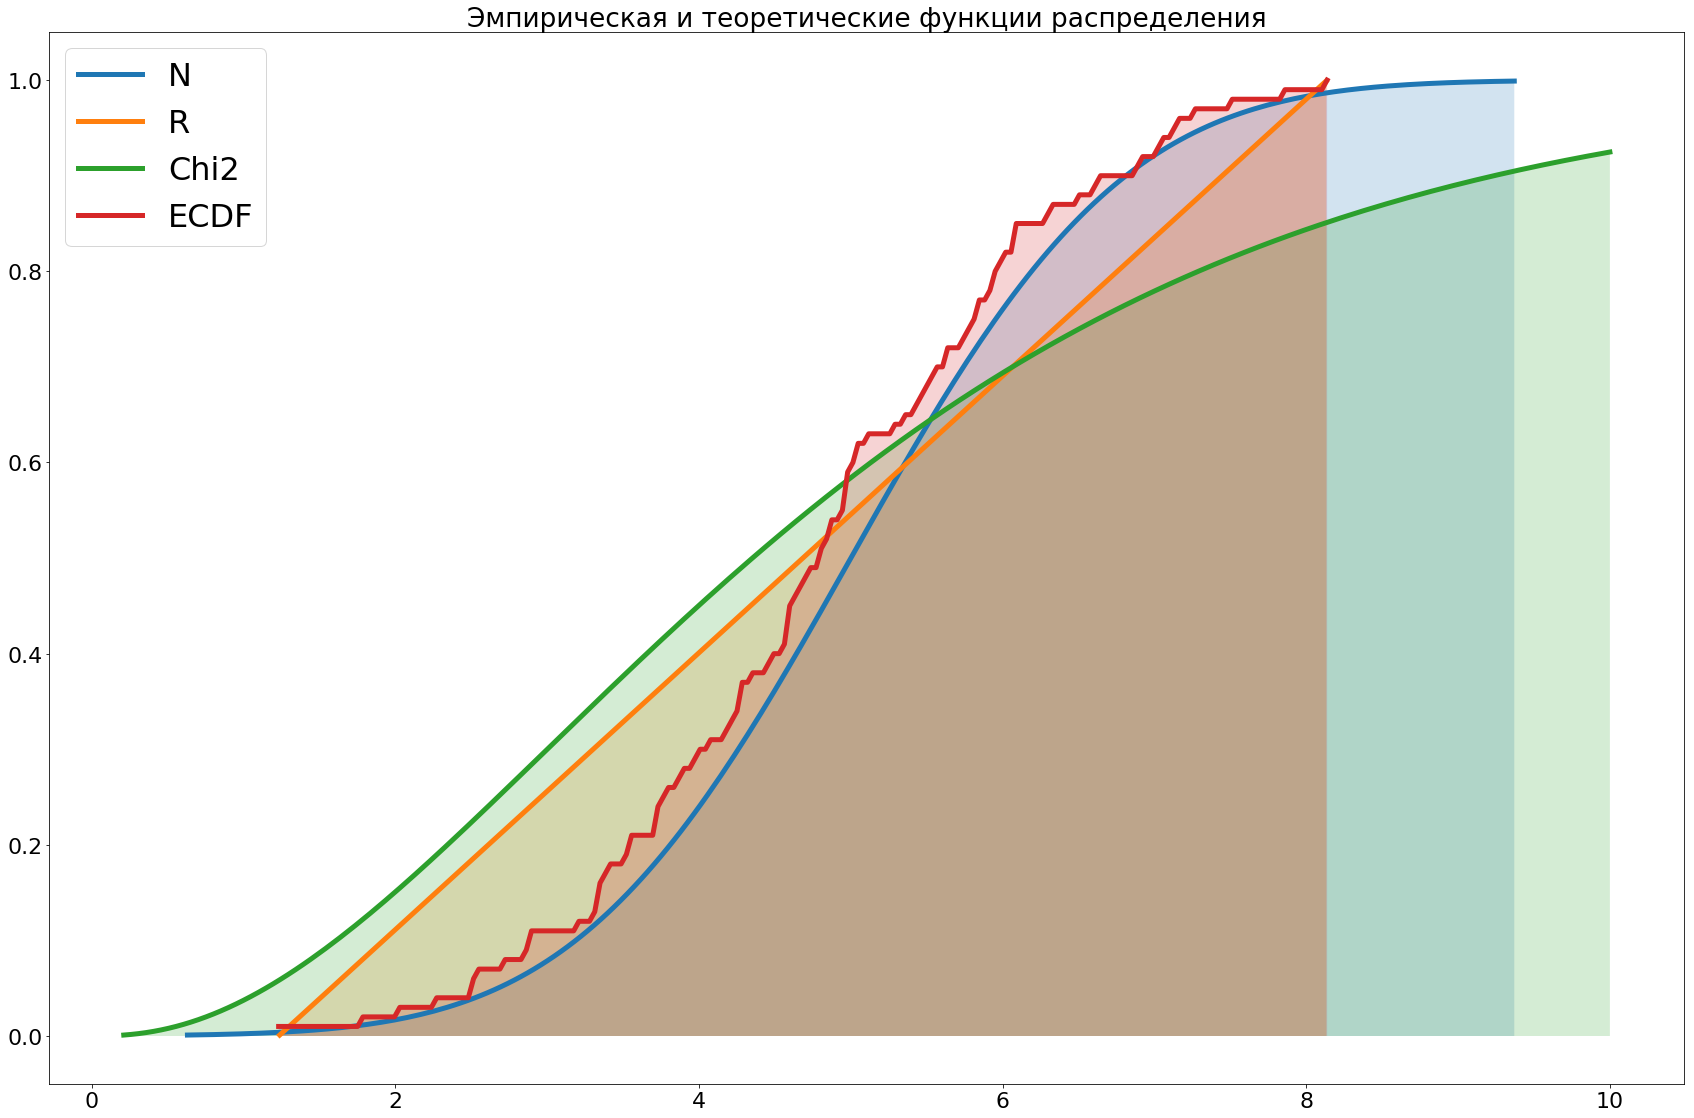

In [23]:
h0_distributions = [
    ('N', normal_dist),
    ('R', uniform_dist),
    ('Chi2', chi2_dist)
]


fig, ax = plt.subplots()
ax.set_title('Эмпирическая и теоретические функции распределения')

for name, dist in h0_distributions:
    domain = np.linspace(
        max(-2.5, dist.ppf(0.001)),
        min(10, dist.ppf(0.999)),
        200
    )
    values = dist.cdf(domain)
    ax.plot(domain, values, lw=5, label=name)
    ax.fill_between(domain, 0, values, alpha=.2)
    
ecdf = ECDF(x.data())
domain = np.linspace(x.min(), x.max(), x.n() * 2)
values = ecdf(domain)
ax.plot(domain, values, lw=5, label='ECDF')
ax.fill_between(domain, 0, values, alpha=.2)

ax.legend(prop={'size': 32})
    
fig.tight_layout()
plt.show()

# 5. Двухвыборочные критерии

In [24]:
print('Характеристики СВ Y:')
table(
    ['Распределение', 'Параметры', 'Мат. ожидание $m$', 'Дисперсия $\\sigma^2$'],
    [['N(5,2)','5,2', Y.mean(), Y.var()]],
)

print('Характеристики выборки y')
table(
    ['Среднее, $\\overline{x}$', 'Оценка дисперсии, $s^2$', 'Оценка с.к.о., $s$'],
    [[y.mean(), y.s()**2, y.s()]]
)

Характеристики СВ Y:


Распределение,Параметры,Мат. ожидание $m$,Дисперсия $\sigma^2$
"N(5,2)","5,2",5.0,2.0000000000000004


Характеристики выборки y


"Среднее, $\overline{x}$","Оценка дисперсии, $s^2$","Оценка с.к.о., $s$"
5.028979676895252,2.1217294090677545,1.4566157383015448


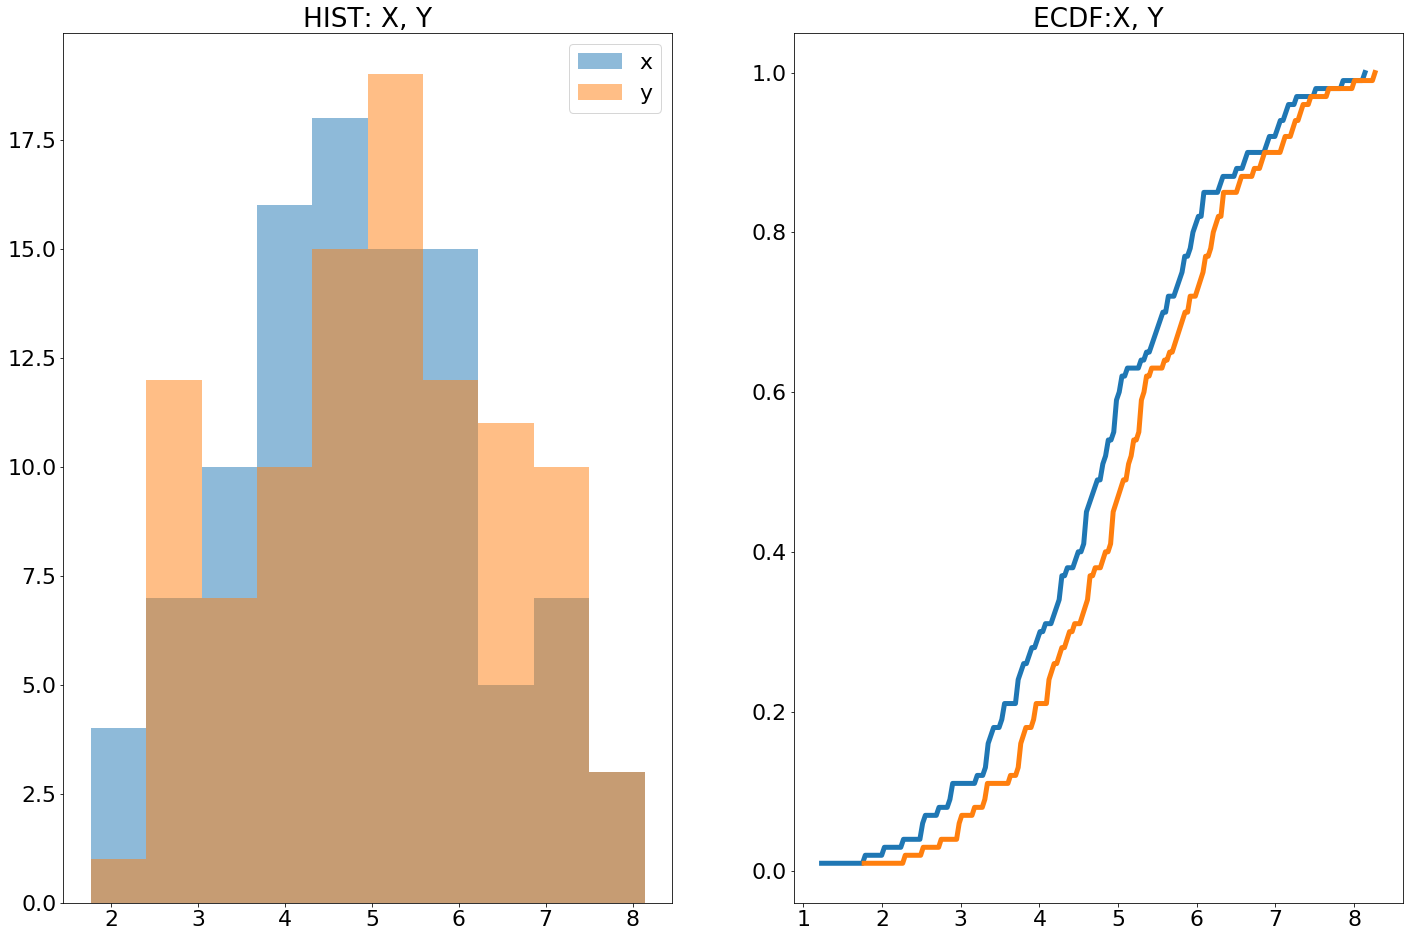

In [25]:
fig, ax = plt.subplots(1, 2)

left_plot = ax[0]
right_plot = ax[1]

min_val = max(x.min(), y.min())
max_val = min(x.max(), y.max())
clipped_x = np.clip(x.data(), min_val, max_val)
clipped_y = np.clip(y.data(), min_val, max_val)

left_plot.set_title('HIST: X, Y')
left_plot.hist(clipped_x, bins=10, label='x', alpha=.5)
left_plot.hist(clipped_y, bins=10, label='y', alpha=.5)
left_plot.legend()


right_plot.set_title('ECDF:X, Y');
xecdf = ECDF(x.data())
xdomain = np.linspace(x.min(), x.max(), x.n() * 2)
xvalues = xecdf(xdomain)
ax[1].plot(xdomain, values, lw=5, label='ECDF')
yecdf = ECDF(y.data())
ydomain = np.linspace(y.min(), y.max(), y.n() * 2)
yvalues = yecdf(ydomain)
ax[1].plot(ydomain, values, lw=5, label='ECDF')


# TODO: ECDF

In [32]:
alpha = 0.01
from s import Pierson2SampledHyp
from functools import *
def sign_test(x, y):
    n = len(list(filter(lambda t: t != 0, list(x - y))))
    K = len(list(filter(lambda t: t > 0, list(x - y))))
    H = K/n
    z = 2 * np.sqrt(n) * (H - 1/2)
    left_p = stats.norm.cdf(z, 0, 1)
    p_value = 2 * min(left_p, 1 - left_p)
    return z, p_value

def chi2_row(text):
    start = math.floor(min(x.min(), y.min()))
    end = math.ceil(max(x.max(), y.max()))
    step = (end - start) / 10
    
    h0 = Pierson2SampledHyp(
        bins=np.arange(start, end + step, step),
    )
    criterion_v, critical_v, p_v, passed = h0.full_test(x, y, alpha)
    decision = 'H0' if passed else 'H1'
    err = "-"
    if decision != 'H0':
        err = "Ошибка 1-го рода"
            
    return [text, "X ~ Y", round(criterion_v, 4), round(p_v, 4), decision, err]
def ks_row(text):
    criterion_v, p_v = stats.ks_2samp(x.data(), y.data())
    decision = ""
    if stats.ksone.ppf(1-alpha, nx) > criterion_v:
        decision = "H0"
    else:
        decision = "H1"
    err = "-"
    if decision != 'H0':
        err = "Ошибка 1-го рода"
    return [text, "X ~ Y", round(criterion_v, 4), round(p_v, 4), decision, err]
def sign_row(text):
    criterion_v, p_v = sign_test(x.data(), y.data())
    decision = ""
    if  abs(criterion_v) < stats.norm.ppf(1-alpha/2, 0, 1):
        decision = "H0"
    else:
        decision = "H1"
    err = "-"
    if decision != 'H0':
        err = "Ошибка 1-го рода"
    return [text, "X ~ Y", round(criterion_v, 4), round(p_v, 4), decision, err]
def u_row(text):
    criterion_v, p_v = stats.mannwhitneyu(x.data(), y.data())
    criterion_v = (criterion_v - nx*ny/2)/np.sqrt(nx*ny*(nx +ny + 1)/12)
    if  abs(criterion_v) < stats.norm.ppf(1-alpha/2, 0, 1):
        decision = "H0"
    else:
        decision = "H1"
    err = "-"
    if decision != 'H0':
        err = "Ошибка 1-го рода"
    return [text, "X ~ Y", round(criterion_v, 4), round(p_v, 4), decision, err]

table(
    [
        'Критерий',
        'Статистическая гипотеза $H_0$',
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha$ = {}'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        chi2_row('Chi-squared'),
        ks_row('KS-test'),
        sign_row('Sign test'),
        u_row('U-test'),
    ]
)

Критерий,Статистическая гипотеза $H_0$,Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha$ = 0.01,Ошибка статистического решения
Chi-squared,X ~ Y,5.0259,0.8894,H0,-
KS-test,X ~ Y,0.14,0.2606,H0,-
Sign test,X ~ Y,-0.8,0.4237,H0,-
U-test,X ~ Y,-1.2461,0.1066,H0,-
